In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

## Loading Data

In this activity, there are two datasets that will be used in the analysis. The first dataset is an export of cyclist, Steve Cassidy's ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `scripts/stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  For reading the data the datetime of the ride is set as the index of the data frame.

In [2]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


As noticed from the above data frame, the date and time has not been localized from strava UTC date time to Sydney Local time. Therefore, date and time conversion is required for the the data frame.

In [3]:
#Conversion of strava UTC datetime to Sydney local time
import datetime
import pytz
t_sydney = pytz.timezone('Australia/Sydney')
strava.index = strava.index.tz_convert(t_sydney)
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-03 07:47:51+11:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 12:36:53+11:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 13:56:00+11:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 16:37:04+11:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-06 06:22:46+11:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [4]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in their documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Combining data

As we have two datasets from different sources for analysing cycling data, we first need to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [5]:
left=strava
right=cheetah
cycling = left.join(right, how='inner')


Let's call the combined datasets as cycling.

In [6]:
cycling.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,109.8,19.0,143.0,False,26.3,649,612.00 m,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


Removing the rows with no measure power can be done by boolean masking as shown below. Let's name our new data frame as 'new_cycling'.

In [7]:
new_cycling = cycling[cycling.device_watts != False]

In [8]:
new_cycling.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-06 08:06:42+11:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780
2018-02-10 06:18:03+11:00,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,...,0,0,0,0,0,0,0,212.726,0.79375,147.7970


To observe if there is any correlation among our interested variables for cycling analysis, producing a correlation table (displayed below) can be a good start.

In [9]:
new_cycling[["distance", "moving_time", "average_watts", "average_heartrate", "NP","TSS", "elevation_gain"]].corr()

,distance,moving_time,average_watts,average_heartrate,NP,TSS
distance,1.000000,0.939383,0.031858,0.114595,0.270703,0.922565
moving_time,0.939383,1.000000,-0.112507,-0.048611,0.044431,0.871368
average_watts,0.031858,-0.112507,1.000000,0.672457,0.772574,0.150163
average_heartrate,0.114595,-0.048611,0.672457,1.000000,0.593091,0.113775
NP,0.270703,0.044431,0.772574,0.593091,1.000000,0.432286
TSS,0.922565,0.871368,0.150163,0.113775,0.432286,1.000000


Understanding what the correlation coefficients in the table above is essential, and data visualization can be helpful. As shown below, pairplot is a good method that can be used to see the overall distributions of our interested variables. Here, we can clearly see what the numbers recorded in the correlation table are referring to and whether or not correlation appears among variables.

C:\Users\josec\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\josec\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


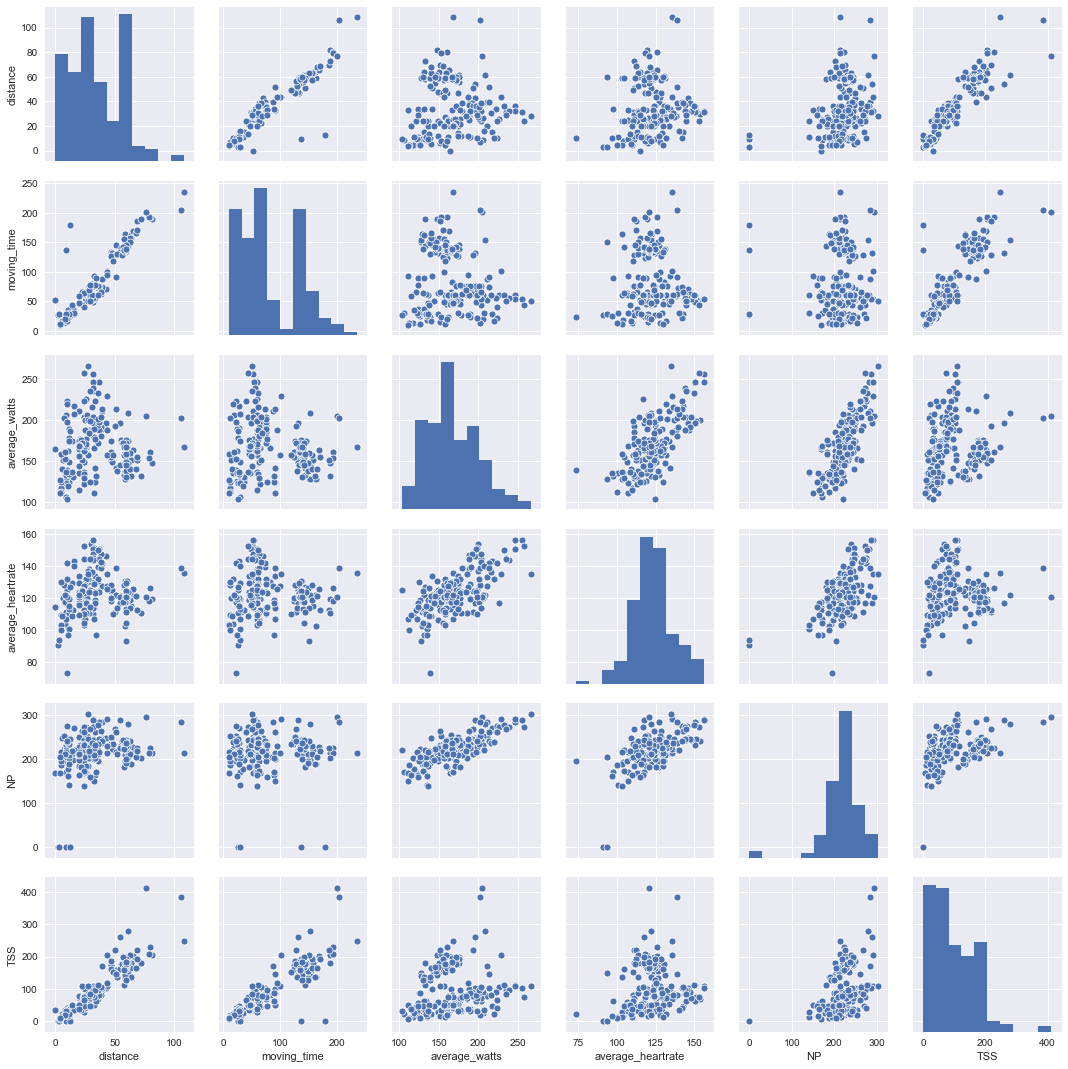

In [10]:
g = sns.pairplot(new_cycling[["distance", "moving_time", "average_watts", "average_heartrate", "NP","TSS", "elevation_gain"]])

#### Overall analysis
In general, the distributions of the key variables in our analysis are mostly skewed with only 'average_watts' and 'average_heartrate' that appear to have a symmetrically normal distribution data.

However, there are some linear relationships that can be observed based on the correlation table and the pairplot:
1. Distance/Training Stress Score (TSS)(positive, linear)
2. Distance/moving_time(positive, linear)
3. Moving_time/TSS(positive, linear)
4. Average_watts/NP(positive, linear)
5. Average_watts/average_heartrate(positive, linear)


Some of the rides are designated as "Race" in the workout_type field, these are where the cyclist is racing and might be expected that these would be the most challenging rides. Normalised Power (NP) is a good measure of how hard a ride is. 

To find out whether or not this hypthesis that races are more challenging than rides is valid, we first need to generate summary table for the dataset that contains only 'Race' in the workout_type column, followed by a similar summary table that contains only 'Ride' in the workout_type column'. 

In [11]:
NP_race = new_cycling[new_cycling.workout_type == 'Race' ]

In [12]:
NP_race.describe()

,average_heartrate,average_temp,average_watts,distance,elapsed_time,kudos,moving_time,axPower,aPower Relative Intensity,aBikeScore,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
count,26.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.000000,29.000000,29.000000
mean,145.561538,12.103448,216.548276,30.631034,52.413793,16.344828,51.965517,242.659103,0.905444,72.244341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,259.659103,0.968878,82.560459
std,7.036765,5.912123,23.868728,10.031775,15.511556,3.497712,16.354298,19.325600,0.072110,23.846316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.503989,0.069045,27.480250
min,128.100000,0.000000,180.000000,7.100000,17.000000,9.000000,13.000000,214.393000,0.799975,19.516600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231.614000,0.864230,20.540800
25%,142.700000,7.000000,198.900000,27.800000,49.000000,15.000000,49.000000,226.363000,0.844640,59.243900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245.365000,0.915540,67.969800
50%,145.700000,14.000000,213.700000,32.100000,54.000000,16.000000,54.000000,237.619000,0.886640,74.044600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,261.378000,0.975293,85.688900
75%,150.650000,16.000000,235.200000,37.000000,61.000000,19.000000,61.000000,257.440000,0.960597,87.184200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,273.058000,1.018870,102.567000
max,156.500000,22.000000,266.600000,51.600000,91.000000,24.000000,91.000000,284.318000,1.060890,127.101000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302.396000,1.128340,145.673000


In [13]:
NP_ride = new_cycling[new_cycling.workout_type == 'Ride' ]

In [14]:
NP_ride.describe()

,average_heartrate,average_temp,average_watts,distance,elapsed_time,kudos,moving_time,axPower,aPower Relative Intensity,aBikeScore,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
count,136.000000,130.000000,151.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.00000,...,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.000000,155.000000,155.000000
mean,118.427206,14.707692,155.631788,37.247097,115.974194,11.116129,92.993548,191.994555,0.716398,92.79048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.701890,0.786201,106.190659
std,10.129879,5.834203,25.576790,23.864189,77.069369,5.636102,56.271431,41.226563,0.153831,70.08485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.088041,0.164508,78.391044
min,73.300000,1.000000,103.700000,2.700000,13.000000,2.000000,10.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,112.775000,10.000000,135.550000,12.200000,44.000000,6.000000,36.500000,178.148500,0.664730,30.42915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.241000,0.747170,34.344500
50%,120.150000,15.000000,156.100000,33.100000,98.000000,10.000000,89.000000,196.417000,0.732900,80.03930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.934000,0.805720,86.060100
75%,124.650000,19.000000,168.850000,59.350000,194.000000,16.000000,140.000000,213.757500,0.797600,147.38050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231.440500,0.863580,168.834000
max,140.300000,31.000000,229.000000,108.200000,260.000000,23.000000,236.000000,284.994000,1.063410,386.24600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,294.308000,1.098160,412.071000


Based on the statistics summary tables for both races and rides as generated above, out of 29 races, the maximum normalised power generated is 302 watts with an average of 260 watts/race. As for the rides, the average NP maintained by cyclist is 211 watts/ride with a maximum NP of 294 watts. In general, the average NP for races is higher than the NP for the rides, which means that the intensity is higher for the races compared to the rides. This proves the initial hypothesis that races are in fact more challenging than rides.

It is interesting to see if there is a correlation between kudos received by the cyclist and our previous interested variables. One way that enables us to see the general correlations is by generating a heatmap as shown below. Here, we can see that the lighter the colour goes the the stronger correlation will be obtained between two variables.

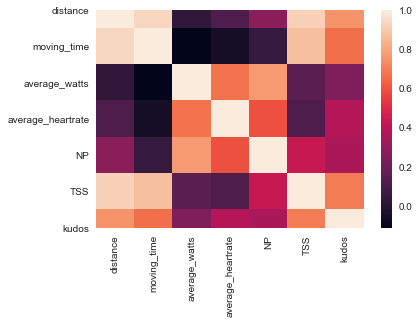

In [15]:
sns.heatmap(new_cycling[["distance", "moving_time", "average_watts", "average_heartrate", "NP","TSS", "elevation_gain", "kudos"]].corr())


As we are interested in finding out what leads to more kudos, we will be focusing only on how 'kudos' relates to other variables. In summary, we can see from the heatmap that strong realtionships can be observed between 'kudos' and  three variables:
1. Distance
2. Moving_time
3. TSS

To see in details how these 3 variables attract kudos, we can plot a scatter plot as the following:      

Text(0.5, 1.0, 'Kudos received by distance')

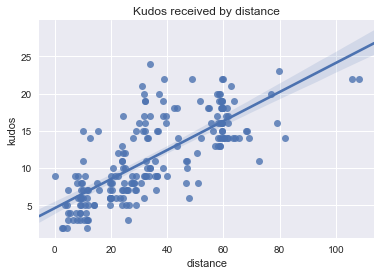

In [16]:
#There's a correlation between distance and kudos. The farther the distance travelled, more kudos gained.
sns.regplot(x='distance',y='kudos',data=new_cycling, fit_reg=True)
plt.title("Kudos received by distance")

Text(0.5, 1.0, 'Kudos received by moving time')

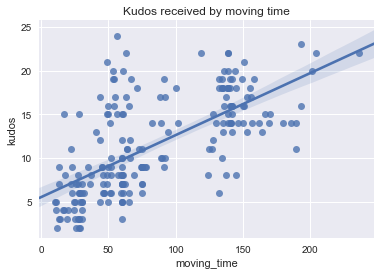

In [17]:
#A correlation can be seen between the distance and moving time elements in the data.
sns.regplot(x='moving_time',y='kudos',data=new_cycling, fit_reg=True)
plt.title("Kudos received by moving time")

Text(0.5, 1.0, 'Kudos received by TSS')

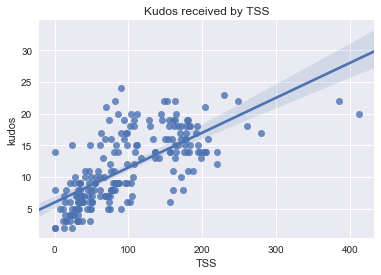

In [18]:
#Similarly, a correlation can be seen between TSS and kudos in the data, where the kudos tend to increase as the TSS increases.
sns.regplot(x='TSS',y='kudos',data=new_cycling, fit_reg=True)
plt.title("Kudos received by TSS")

In [19]:
Cycling_monthly = new_cycling.resample('M').sum()

C:\Users\josec\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Text(0.5, 1.0, 'Summary of monthly cycling data')

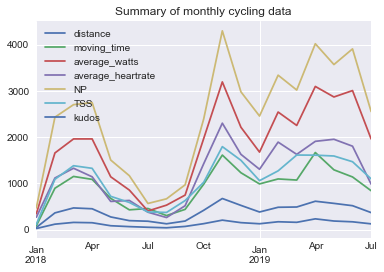

In [20]:
Cycling_monthly.plot(y=["distance", "moving_time", "average_watts", "average_heartrate", "NP","TSS", "kudos"], use_index=True)
plt.title("Summary of monthly cycling data")

In general, all of the variables appear to show similar trends, as shown in the above summary graph for cycling analysis. The trends tend to increase in the warmer months and decrease during the colder months (May to September). Cyclist looks to be more active in the warmer months than in the colder months.